In [1]:
# @title Step 0.1: Setup and Global Configuration
!pip install geopandas shapely folium mapclassify sqlalchemy plotly -q

import pandas as pd
import geopandas as gpd
import sqlite3
import folium
from shapely.geometry import Point
import numpy as np
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

#Govt. Data Links
CDC_PLACES_URL = "https://chronicdata.cdc.gov/api/views/cwsq-ngmh/rows.csv?accessType=DOWNLOAD"
VA_FACILITY_URL = "https://www.data.va.gov/api/views/5xcm-tiar/rows.csv?accessType=DOWNLOAD"
VET_POP_URL = "https://www.data.va.gov/api/views/jrjd-qghv/rows.csv?accessType=DOWNLOAD"
COUNTIES_GEOJSON_URL = 'https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json'
df_geocode_cache = pd.read_csv(
    'https://raw.githubusercontent.com/amaljain10/Geospatial-Veteran-Healthcare-Access-Analysis/main/geocode_cache.csv'
)

#Global Analysis Parameters
# This value is exactly 40 mile radius. It defines the maximum acceptable distance for access to a VA facility. Any county centroid falling outside this 40-mile radius is classified as a "Service Desert."
BUFFER_METERS = 64373
# This value defines a High-Impact Desert. It's the minimum number of veterans a county must have to be considered a major strategic priority. Counties that are "Service Deserts" and have over 5,000 veterans are considered for high-resource deployment due to the large population size.
HIGH_VET_POP_THRESHOLD = 5000

# Helper function for FIPS standardization
def standardize_fips(series):
    return series.astype(str).str.zfill(5)

print("Setup complete. Ready to load data.")

Setup complete. Ready to load data.


In [2]:
# @title Step 1.1: Load and Standardize Veteran Population Data
# 1. Load Veteran Population Data
df_vet_pop = pd.read_csv(VET_POP_URL)

# Check for the column name 'Veterans' or 'TOTVET_2023'
if 'Veterans' in df_vet_pop.columns:
    df_vet_pop = df_vet_pop.rename(columns={'Veterans': 'TOTVET_2023'})
else:
    raise ValueError("Could not find Veteran Population column.")

# FIPS FIX 1: Convert to 5-digit string
df_vet_pop['FIPS'] = standardize_fips(df_vet_pop['FIPS'])

# Filter for 2023 data
df_vet_pop['Date'] = pd.to_datetime(df_vet_pop['Date'])
df_vet_pop = df_vet_pop[df_vet_pop['Date'].dt.year == 2023]

print(f"Loaded {len(df_vet_pop)} Vet Pop records. FIPS standardized and filtered for 2023.")

df_vet_pop_clean = df_vet_pop.groupby(['Date', 'FIPS'], as_index=False)['TOTVET_2023'].sum()
df_vet_pop_clean.head()

Loaded 25200 Vet Pop records. FIPS standardized and filtered for 2023.


/tmp/ipython-input-3204690566.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_vet_pop['Date'] = pd.to_datetime(df_vet_pop['Date'])


,Date,FIPS,TOTVET_2023
0,2023-09-30,01001,5889
1,2023-09-30,01003,19139
2,2023-09-30,01005,1529
3,2023-09-30,01007,1093
4,2023-09-30,01009,3179


In [3]:
# @title Step 1.2: Load and Standardize CDC Chronic Need Data (Using 'Disability' Proxy)
# 1. Load CDC Places Data (High-Need Proxy)
df_places = pd.read_csv(CDC_PLACES_URL)

#Pivot to a robust measure ('Disability')
df_places['Measure_Clean'] = df_places['Measure'].str.strip().str.lower()

# Filter for a robust proxy for chronic need: General Disability prevalence
df_places = df_places[
    (df_places['Measure_Clean'] == 'any disability among adults')
].copy()

df_places['Data_Value'] = pd.to_numeric(df_places['Data_Value'], errors='coerce')

# Grouped the data by FIPS and taking the mean to ensure one reliable value per county
df_places_grouped = df_places.groupby('CountyFIPS')['Data_Value'].mean().reset_index()

df_places = df_places_grouped.rename(columns={'CountyFIPS': 'FIPS', 'Data_Value': 'DISABILITY_Prevalence'})

# FIPS FIX 2: Convert to 5-digit string
df_places['FIPS'] = standardize_fips(df_places['FIPS'])

#Rename the global variable df_places to use the new column name
print(f"Loaded {len(df_places)} unique county DISABILITY Prevalence records. FIPS standardized.")

Loaded 2956 unique county DISABILITY Prevalence records. FIPS standardized.


In [4]:
# @title Step 1.3: Load and Standardize Geospatial Data & VA Facilities
# 1. Load County GeoJSON
gdf_counties = gpd.read_file(COUNTIES_GEOJSON_URL)
# FIPS FIX 3: Convert the GeoJSON's ID to FIPS string
gdf_counties['FIPS'] = standardize_fips(gdf_counties['id'])
gdf_counties.drop(columns=['id'], inplace=True)

# 2. Load VA Facility Data (Combined with your geocache file)
try:
    df_facilities = pd.read_csv(VA_FACILITY_URL)

    df_cache = df_geocode_cache

    # Recreate the address key for merging with the cache
    df_facilities['full_address'] = df_facilities['S_ADD1'] + ', ' + df_facilities['S_CITY'] + ', ' + df_facilities['S_STATE'] + ' ' + df_facilities['S_ZIP'].astype(str)

    df_facilities = df_facilities.merge(
        df_cache[['full_address', 'latitude', 'longitude']],
        on='full_address',
        how='left',
        suffixes=('', '_cached')
    )

    # Final cleanup of facility data
    global df_clean_facilities
    df_clean_facilities = df_facilities[df_facilities['PRIM_SVC'] == 'VAMC'].copy()
    df_clean_facilities = df_clean_facilities.dropna(subset=['latitude', 'longitude'])
    df_clean_facilities = df_clean_facilities.rename(columns={'Facility': 'name', 'S_STATE': 'State', 'PRIM_SVC': 'Facility Type'})

    print(f"Loaded {len(df_clean_facilities)} geocoded VA Medical Centers.")

except Exception as e:
    print(f"CRITICAL ERROR LOADING FACILITIES/CACHE: {e}. Please ensure 'geocode_cache.csv' is uploaded.")
    raise

print("Data Loading complete")

Loaded 98 geocoded VA Medical Centers.
Data Loading complete


In [5]:
# @title Step 1.4: Perform Aggregation and Merging of Datasets

# Aggregate Veteran Population (TOTVET_2023)
# We sum the values in case the raw data was split (e.g., by age or gender)
print(f"Original df_vet_pop rows: {len(df_vet_pop)}")
df_vet_pop_clean = df_vet_pop.groupby('FIPS')['TOTVET_2023'].sum().reset_index()
print(f"Cleaned df_vet_pop unique FIPS rows: {len(df_vet_pop_clean)}")

# Aggregate CDC PLACES Data (DISABILITY_Prevalence)
# Rationale: This is a percentage/rate. We use the MEAN if multiple entries exist
# (e.g., breakdown by race/age, which should be averaged to get a representative county rate).
print(f"Original df_places rows: {len(df_places)}")

# Group by FIPS and calculate the mean of the prevalence rate
df_places_clean = df_places.groupby('FIPS')['DISABILITY_Prevalence'].mean().reset_index()
print(f"Cleaned df_places unique FIPS rows: {len(df_places_clean)}")


# 3. Merge Data with County Geometry
# Merge using the cleaned, aggregated dataframes onto the county GeoDataFrame
gdf_merged = gdf_counties.merge(df_vet_pop_clean, on='FIPS', how='left')
gdf_merged = gdf_merged.merge(df_places_clean, on='FIPS', how='left')

# Clean and set defaults
# Fill NaN with 0 for counties lacking data (e.g., non-contiguous US territories or missing data)
gdf_merged['TOTVET_2023'] = gdf_merged['TOTVET_2023'].fillna(0)
gdf_merged['DISABILITY_Prevalence'] = gdf_merged['DISABILITY_Prevalence'].fillna(0)

# Filter for relevant counties (those with veterans)
gdf_merged = gdf_merged[gdf_merged['TOTVET_2023'] > 0].copy()
print(f"Counties Merged with Vet Pop and CDC data: {len(gdf_merged)}")


# 4. Dynamic Threshold Calculation
# Calculate descriptive statistics for DISABILITY Prevalence
adl_stats = gdf_merged['DISABILITY_Prevalence'].describe(percentiles=[.50, .75, .90])
print("\n--- DISABILITY Prevalence Descriptive Statistics (Crude % of All Adults) ---")
print(adl_stats)

# Set the threshold to the 75th percentile (P75)
global HIGH_NEED_THRESHOLD
HIGH_NEED_THRESHOLD = adl_stats['75%']

print(f"--> Dynamic HIGH_NEED_THRESHOLD set to 75th percentile: {HIGH_NEED_THRESHOLD:.2f}%")

# 5. Convert Facilities to GeoDataFrame (Points)
# This uses the cleaned facility data
global gdf_facilities_points
gdf_facilities_points = gpd.GeoDataFrame(
    df_clean_facilities,
    geometry=gpd.points_from_xy(df_clean_facilities.longitude, df_clean_facilities.latitude),
    crs="EPSG:4326"
)

# 6. Define "High Need" Counties
# Identify counties that meet or exceed the calculated P75 threshold
global gdf_high_need_counties
gdf_high_need_counties = gdf_merged[gdf_merged['DISABILITY_Prevalence'] >= HIGH_NEED_THRESHOLD].copy()
print(f"Identified {len(gdf_high_need_counties)} High Need Counties (Disability Prevalence > {HIGH_NEED_THRESHOLD:.2f}%).")

Original df_vet_pop rows: 25200
Cleaned df_vet_pop unique FIPS rows: 3150
Original df_places rows: 2956
Cleaned df_places unique FIPS rows: 2956
Counties Merged with Vet Pop and CDC data: 3131

--- DISABILITY Prevalence Descriptive Statistics (Crude % of All Adults) ---
count    3131.000000
mean       32.939439
std         9.809412
min         0.000000
50%        34.275000
75%        38.458333
90%        42.200000
max        50.475000
Name: DISABILITY_Prevalence, dtype: float64
--> Dynamic HIGH_NEED_THRESHOLD set to 75th percentile: 38.46%
Identified 783 High Need Counties (Disability Prevalence > 38.46%).


In [6]:
# @title Step 2: Geospatial Buffering and Desert Identification

# Reproject to Projected CRS (Meters) for Accurate Buffering
TARGET_CRS = "EPSG:5070"
gdf_facilities_proj = gdf_facilities_points.to_crs(TARGET_CRS)
gdf_counties_proj = gdf_merged.to_crs(TARGET_CRS)

# 1. Create the VA Access Buffer (Service Area)
facility_buffer = gdf_facilities_proj.buffer(BUFFER_METERS)
coverage_area = facility_buffer.unary_union

# 2. Identify "Desert" Counties (those NOT intersecting the coverage area)
covered_area = gpd.GeoSeries(coverage_area, crs=TARGET_CRS)
desert_counties_proj = gdf_counties_proj[~gdf_counties_proj.geometry.intersects(covered_area.iloc[0])].copy()

# 3. Identify Highest Priority Deserts
highest_priority_deserts = desert_counties_proj[
    (desert_counties_proj['DISABILITY_Prevalence'] >= HIGH_NEED_THRESHOLD)
].copy()

# 4. Identify High-Impact Deserts (Veteran Population based)
high_impact_vet_deserts = desert_counties_proj[
    (desert_counties_proj['TOTVET_2023'] >= HIGH_VET_POP_THRESHOLD)
].copy()


print(f"Total Unique Counties identified as 'Deserts' (outside 40-mile radius): {len(desert_counties_proj)}")
print(f"Highest Priority Deserts (Disability Prevalence > {HIGH_NEED_THRESHOLD:.2f}%): {len(highest_priority_deserts)}")
print(f"High-Impact Deserts (Vet Pop > {HIGH_VET_POP_THRESHOLD}): {len(high_impact_vet_deserts)}")

Total Unique Counties identified as 'Deserts' (outside 40-mile radius): 2092
Highest Priority Deserts (Disability Prevalence > 38.46%): 609
High-Impact Deserts (Vet Pop > 5000): 287


/tmp/ipython-input-4066552749.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  coverage_area = facility_buffer.unary_union


In [7]:
# @title Step 3: Interactive Visualization

from IPython.display import display
# Convert all GeoDataFrames back to WGS84 (EPSG:4326) for Folium

highest_priority_4326 = highest_priority_deserts.to_crs("EPSG:4326")
high_need_counties_4326 = gdf_high_need_counties.to_crs("EPSG:4326")
coverage_4326 = gpd.GeoSeries(coverage_area, crs=TARGET_CRS).to_crs("EPSG:4326").to_frame(name='geometry')
facilities_4326 = gdf_facilities_points.to_crs("EPSG:4326")

GITHUB_RAW = "https://raw.githubusercontent.com/amaljain10/Geospatial-Veteran-Healthcare-Access-Analysis/main/"


# Create a base map centered on the US
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4, tiles='cartodbpositron')

# Prepare GeoDataFrames by dropping the 'Date' column if it exists, to avoid JSON serialization errors
# and remove unnecessary columns for this visualization
high_need_counties_4326_cleaned = high_need_counties_4326.drop(columns=['Date'], errors='ignore')
highest_priority_4326_cleaned = highest_priority_4326.drop(columns=['Date'], errors='ignore')

# 1. High-Need Choropleth
folium.Choropleth(
    geo_data=GITHUB_RAW + "high_need_counties.geojson",
    data=high_need_counties_4326_cleaned,
    columns=["FIPS", "DISABILITY_Prevalence"],
    key_on="feature.properties.FIPS",
    fill_color="YlOrRd",
    fill_opacity=0.5,
    line_opacity=0.1,
    legend_name="Chronic Need (Disability %)",
    name="High Need Counties",
).add_to(m)

# 2. Highest Priority
folium.GeoJson(
    GITHUB_RAW + "highest_priority.geojson",
    name="Priority Deserts",
    style_function=lambda x: {
        "fillColor": "#8b0000",
        "color": "red",
        "weight": 3,
        "fillOpacity": 0.8,
    }
).add_to(m)

# 3. Coverage Areas
folium.GeoJson(
    GITHUB_RAW + "coverage_zones.geojson",
    name="VA 40-mile Coverage",
    style_function=lambda x: {
        "fillColor": "blue",
        "color": "blue",
        "weight": 1,
        "fillOpacity": 0.1,
    }
).add_to(m)

# 4. Facilities
folium.GeoJson(
    GITHUB_RAW + "va_facilities.geojson",
    name="VA Facilities",
    marker=folium.CircleMarker(radius=3, color="green")
).add_to(m)

In [8]:
# @title Step 4.1: Validation Check: Unique Counties in Merged Data

# Check the number of unique FIPS codes in the merged data
unique_fips_count = gdf_merged['FIPS'].nunique()
print(f"Total Unique FIPS Codes (Counties) in the Merged Data: {unique_fips_count:,}")

# Check the number of unique FIPS codes in the dataset filtered for Veterans
counties_with_vets = gdf_merged[gdf_merged['TOTVET_2023'] > 0]['FIPS'].nunique()
print(f"Unique FIPS Codes (Counties) with a Veteran Population: {counties_with_vets:,}")

Total Unique FIPS Codes (Counties) in the Merged Data: 3,131
Unique FIPS Codes (Counties) with a Veteran Population: 3,131


In [9]:
# @title Step 4.2: State Concentration Analysis

# We need the state FIPS code (first two digits) to group accurately.
highest_priority_deserts['State_FIPS'] = highest_priority_deserts['FIPS'].str.slice(0, 2)

# Load a FIPS to State Name mapping
state_fips_map = {
    '01': 'Alabama', '02': 'Alaska', '04': 'Arizona', '05': 'Arkansas', '06': 'California', '08': 'Colorado', '09': 'Connecticut', '10': 'Delaware', '11': 'District of Columbia', '12': 'Florida', '13': 'Georgia', '15': 'Hawaii', '16': 'Idaho', '17': 'Illinois', '18': 'Indiana', '19': 'Iowa', '20': 'Kansas', '21': 'Kentucky', '22': 'Louisiana', '23': 'Maine', '24': 'Maryland', '25': 'Massachusetts', '26': 'Michigan', '27': 'Minnesota', '28': 'Mississippi', '29': 'Missouri', '30': 'Montana', '31': 'Nebraska', '32': 'Nevada', '33': 'New Hampshire', '34': 'New Jersey', '35': 'New Mexico', '36': 'New York', '37': 'North Carolina', '38': 'North Dakota', '39': 'Ohio', '40': 'Oklahoma', '41': 'Oregon', '42': 'Pennsylvania', '44': 'Rhode Island', '45': 'South Carolina', '46': 'South Dakota', '47': 'Tennessee', '48': 'Texas', '49': 'Utah', '50': 'Vermont', '51': 'Virginia', '53': 'Washington', '54': 'West Virginia', '55': 'Wisconsin', '56': 'Wyoming', '72': 'Puerto Rico'
}

highest_priority_deserts['State_Name'] = highest_priority_deserts['State_FIPS'].map(state_fips_map)

# Group by state and sum the veteran population
state_summary = highest_priority_deserts.groupby('State_Name')['TOTVET_2023'].sum().sort_values(ascending=False)

print("\n--- Top 5 States with Highest Veteran Population in Highest Priority Deserts ---")
print(state_summary.head(5).to_frame())


--- Top 5 States with Highest Veteran Population in Highest Priority Deserts ---
            TOTVET_2023
State_Name             
Alabama        120335.0
Tennessee      112050.0
Missouri       106958.0
Oklahoma        79806.0
Louisiana       76937.0


In [10]:
# @title Step 4.3: County Breakdown in Highest Priority Deserts
# 1. Identify the list of the top 5 state names
top_5_states = ['Alabama', 'Tennessee', 'Missouri', 'Oklahoma', 'Louisiana']

# 2. Filter the data to include only the counties in those top 5 states
top_5_counties_df = highest_priority_deserts[
    highest_priority_deserts['State_Name'].isin(top_5_states)
].copy()

# 3. Select the most relevant columns and sort them to show the highest impact counties first
county_breakdown = top_5_counties_df[
    ['State_Name', 'NAME', 'FIPS', 'TOTVET_2023']
].rename(columns={'NAME': 'COUNTY NAME'}).sort_values(by=['State_Name', 'TOTVET_2023'], ascending=[True, False])

# 4. Print the full detailed table
print("\n--- Detailed County Breakdown: Highest Priority Deserts in Top 5 States ---")
print(county_breakdown.to_markdown(index=False))


--- Detailed County Breakdown: Highest Priority Deserts in Top 5 States ---
| State_Name   | COUNTY NAME          |   FIPS |   TOTVET_2023 |
|:-------------|:---------------------|-------:|--------------:|
| Alabama      | Montgomery           |  01101 |         18921 |
| Alabama      | Calhoun              |  01015 |          8829 |
| Alabama      | Houston              |  01069 |          8597 |
| Alabama      | Coffee               |  01031 |          7429 |
| Alabama      | Dale                 |  01045 |          7177 |
| Alabama      | Russell              |  01113 |          6720 |
| Alabama      | Etowah               |  01055 |          6072 |
| Alabama      | Marshall             |  01095 |          5743 |
| Alabama      | Talladega            |  01121 |          5059 |
| Alabama      | DeKalb               |  01049 |          3444 |
| Alabama      | Jackson              |  01071 |          3015 |
| Alabama      | Tallapoosa           |  01123 |          2911 |
| Alabama    

In [11]:
# @title Step 4.3: Total Veterans in Highest Priority Deserts

total_vets_in_high_priority_deserts = highest_priority_deserts['TOTVET_2023'].sum()

# Total US Veteran Population (from Google Search for context)
# We will use 15.8 million, the 2023 estimate from the Census Bureau.
TOTAL_US_VET_POP = 15800000

percentage_vets_in_deserts = (total_vets_in_high_priority_deserts / TOTAL_US_VET_POP) * 100

print(f"Total Veterans in 608 Highest Priority Deserts: {total_vets_in_high_priority_deserts:,.0f}")
print(f"Percentage of Total US Veterans Impacted: {percentage_vets_in_deserts:.2f}%")

Total Veterans in 608 Highest Priority Deserts: 1,008,806
Percentage of Total US Veterans Impacted: 6.38%


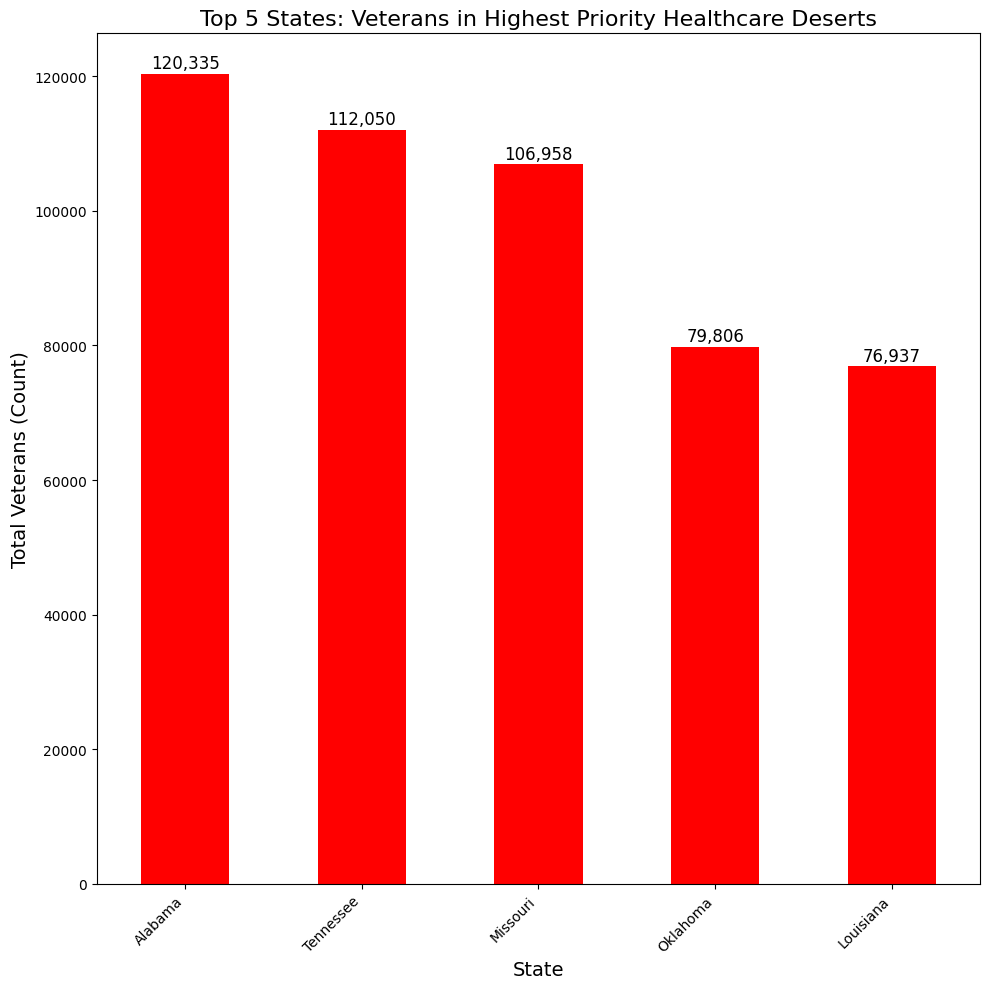

In [12]:
# @title Step 4.4: Top 5 States Veterans in Deserts (Bar Chart)
%matplotlib inline
import matplotlib.pyplot as plt

if 'highest_priority_deserts' in globals():
    temp_df = highest_priority_deserts.copy()
    temp_df['State_FIPS'] = temp_df['FIPS'].str.slice(0, 2)
    state_fips_map = {
        '01': 'Alabama', '02': 'Alaska', '04': 'Arizona', '05': 'Arkansas', '06': 'California', '08': 'Colorado', '09': 'Connecticut', '10': 'Delaware', '11': 'District of Columbia', '12': 'Florida', '13': 'Georgia', '15': 'Hawaii', '16': 'Idaho', '17': 'Illinois', '18': 'Indiana', '19': 'Iowa', '20': 'Kansas', '21': 'Kentucky', '22': 'Louisiana', '23': 'Maine', '24': 'Maryland', '25': 'Massachusetts', '26': 'Michigan', '27': 'Minnesota', '28': 'Mississippi', '29': 'Missouri', '30': 'Montana', '31': 'Nebraska', '32': 'Nevada', '33': 'New Hampshire', '34': 'New Jersey', '35': 'New Mexico', '36': 'New York', '37': 'North Carolina', '38': 'North Dakota', '39': 'Ohio', '40': 'Oklahoma', '41': 'Oregon', '42': 'Pennsylvania', '44': 'Rhode Island', '45': 'South Carolina', '46': 'South Dakota', '47': 'Tennessee', '48': 'Texas', '49': 'Utah', '50': 'Vermont', '51': 'Virginia', '53': 'Washington', '54': 'West Virginia', '55': 'Wisconsin', '56': 'Wyoming', '72': 'Puerto Rico'
    }
    temp_df['State_Name'] = temp_df['State_FIPS'].map(state_fips_map)
    state_summary = temp_df.groupby('State_Name')['TOTVET_2023'].sum().sort_values(ascending=False).head(5)
else:
    print("Error: 'highest_priority_deserts' DataFrame is not available. Please run Step 2 first.")
    state_summary = None

if state_summary is not None:
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    state_summary.plot(kind='bar', ax=ax, color='red')

    # Formatting
    ax.set_title('Top 5 States: Veterans in Highest Priority Healthcare Deserts', fontsize=16)
    ax.set_xlabel('State', fontsize=14)
    ax.set_ylabel('Total Veterans (Count)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    ax.ticklabel_format(style='plain', axis='y') # Prevent scientific notation

    # Add values on top of bars
    for i, v in enumerate(state_summary.values):
        ax.text(i, v + 200, f'{v:,.0f}', ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()